In [31]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import ray

from tools_ryu import mytool
from multi_run_v3.data_pp import DataPreprocess
from multi_run_v3.momentum import make_group_mask
from multi_run_v3.momentum_strategy_weekly import *

In [2]:
data = pd.read_pickle("Data/cmktcap_data_final.pickle")

days_lst = ["MON","TUE","WED","THU","FRI","SAT","SUN"]

In [3]:
data_pp = DataPreprocess()
data_pp.initialize(data=data)
data_pp.make_mask(mktcap_thresh=1_000_000,
                  vol_thresh=1_000_000,
                  ma=True)

In [4]:
# Ray Data 생성
ray_price = ray.put(data_pp.price_df)
ray_mktcap = ray.put(data_pp.mktcap_df)
ray_vol = ray.put(data_pp.vol_df)
ray_daily_rtn = ray.put(data_pp.daily_rtn_df)
ray_weekly_rtn = ray.put(data_pp.weekly_rtn_df)
ray_mask = ray.put(data_pp.mask)

In [ ]:
# Terra Luna 제거

#price_pp = cmkt_data["price"].drop("4172", axis=1)
#mktcap_pp = cmkt_data["mktcap"].drop("4172", axis=1)
#vol_pp = cmkt_data["vol"].drop("4172", axis=1)
#ray_price = ray.put(price_pp)
#ray_mktcap = ray.put(mktcap_pp)
#ray_vol = ray.put(vol_pp)

### Weekly: Value Weighted, Marketcap Capped 

In [5]:
momentum_capped_cmkt = {}

momentum_capped_future = [weekly_momentum_value_weighted_capped.remote(price_df=ray_price,
                                                                       mktcap_df=ray_mktcap,
                                                                       daily_rtn_df = ray_daily_rtn,
                                                                       weekly_rtn_df = ray_weekly_rtn,
                                                                       mask_df = ray_mask,
                                                                       fee_rate = 0.0015,
                                                                       n_group=5,
                                                                       day_of_week=day,
                                                                       num_cap=0.95 # 5% capped
                                                                       ) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [6]:
momentum_result_dict_c = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

In [8]:
font = {'family': 'serif', 'style': 'italic'}

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

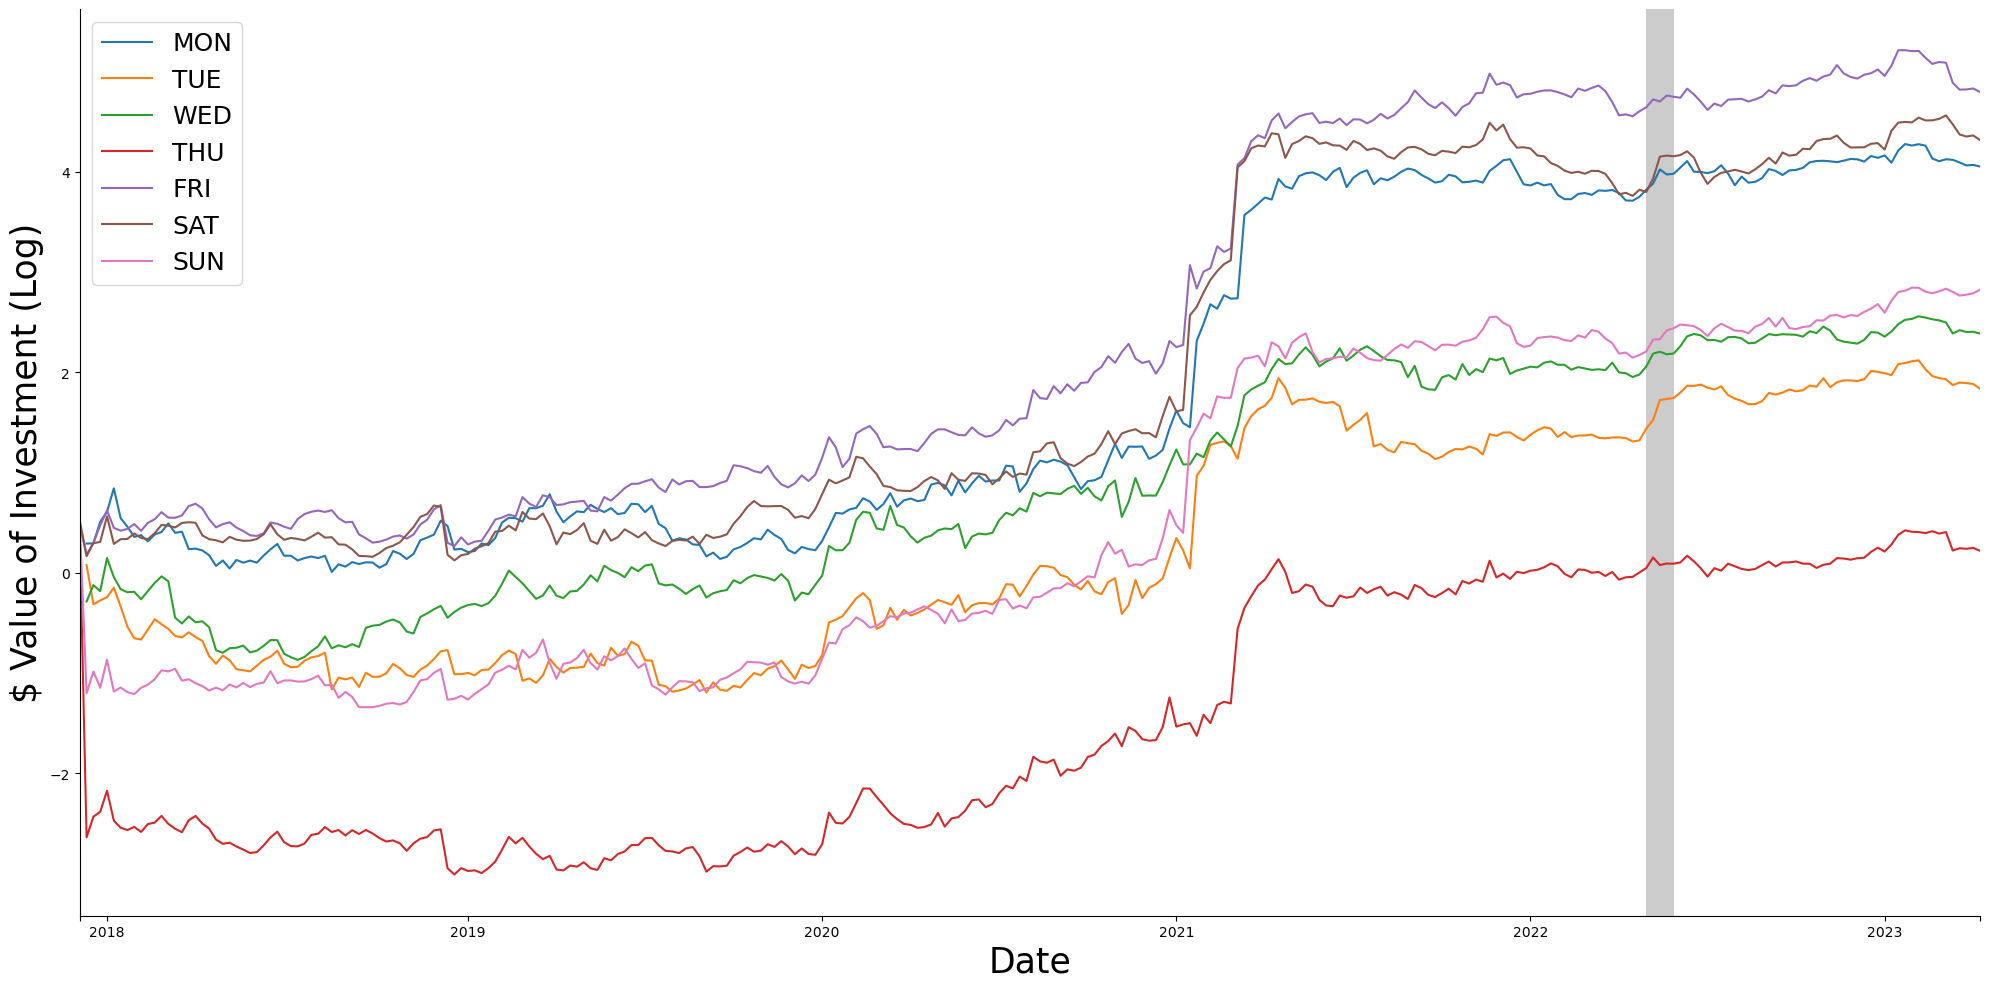

In [51]:
for day, pf_dict in momentum_result_dict_c.items():
    np.log(pf_dict["LS-cross"]).plot(figsize=(20,10), label=day)

plt.legend(fontsize=18)
plt.xlabel("Date", fontsize=25)
plt.ylabel("\$ Value of Investment (Log)", fontsize=25)

start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2022-05-30')

plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)
plt.minorticks_off()
plt.tight_layout()

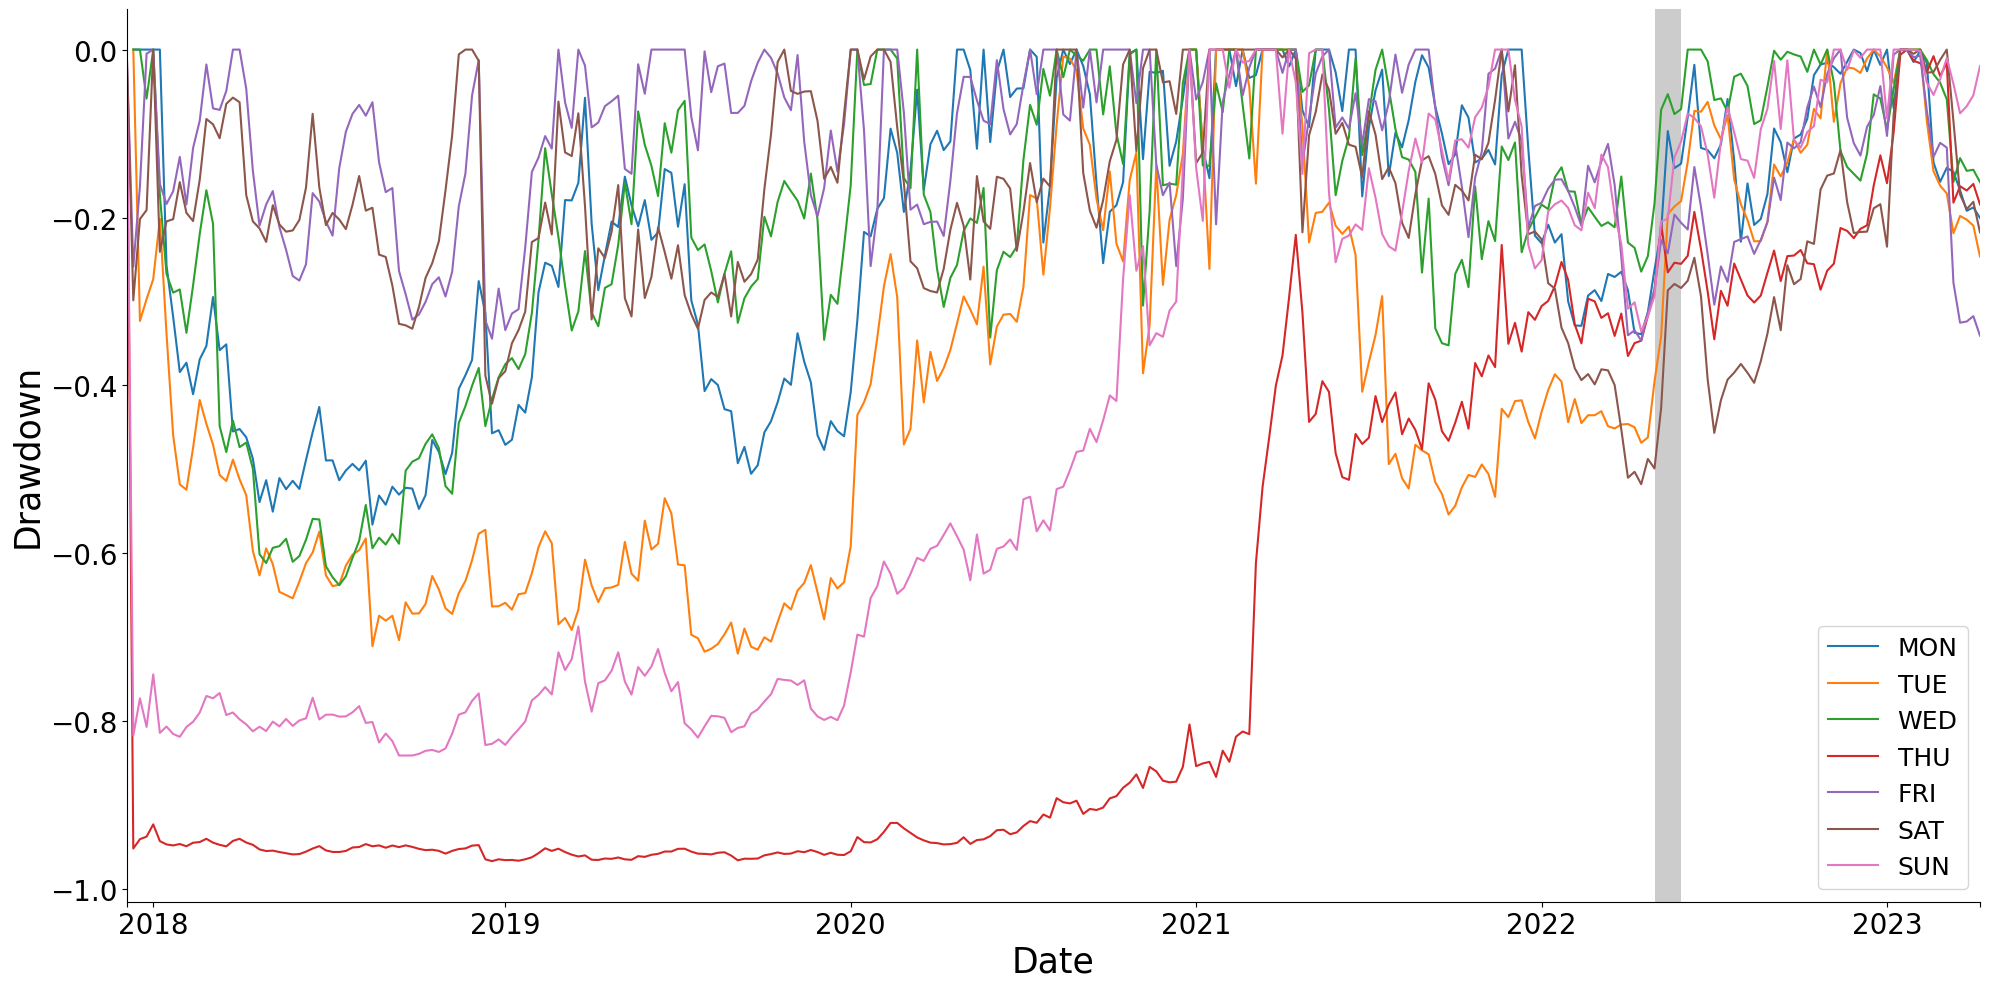

In [54]:
for day, pf_dict in momentum_result_dict_c.items():
    peak = pf_dict["LS-cross"].cummax()
    dd = (pf_dict["LS-cross"]-peak) / peak
    
    dd.plot(figsize=(20,10), fontsize=20, label=day)
    
plt.xlabel("Date", fontsize=25)
plt.ylabel("Drawdown", fontsize=25)
plt.legend(fontsize=18)

start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2022-05-30')

plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [55]:
for day, pf_dict in momentum_result_dict_c.items():
    peak = pf_dict["LS-cross"].pct_change()

{'MON': {'Long_Q1': 2017-12-11    0.927173
  2017-12-18    1.355931
  2017-12-25    1.187039
  2018-01-01    1.502461
  2018-01-08    1.742070
                  ...   
  2023-03-13    0.007728
  2023-03-20    0.008070
  2023-03-27    0.007661
  2023-04-03    0.007957
  2023-04-10    0.008170
  Length: 279, dtype: float64,
  'Long_Q2': 2017-12-11    0.958628
  2017-12-18    2.063257
  2017-12-25    2.206101
  2018-01-01    2.287313
  2018-01-08    2.933741
                  ...   
  2023-03-13    0.163501
  2023-03-20    0.163889
  2023-03-27    0.157539
  2023-04-03    0.167178
  2023-04-10    0.170957
  Length: 279, dtype: float64,
  'Long_Q3': 2017-12-11    1.473201
  2017-12-18    3.363669
  2017-12-25    3.605189
  2018-01-01    3.621884
  2018-01-08    4.510836
                  ...   
  2023-03-13    1.074333
  2023-03-20    1.099854
  2023-03-27    1.075738
  2023-04-03    1.119531
  2023-04-10    1.167750
  Length: 279, dtype: float64,
  'Long_Q4': 2017-12-11    1.160948
  2017

Volume_weighted_capped

In [12]:
momentum_capped_cmkt = {}

momentum_capped_future = [weekly_momentum_volume_weighted_capped.remote(price_df=ray_price,
                                                                       mktcap_df=ray_mktcap,
                                                                       vol_df = ray_vol,
                                                                       daily_rtn_df = ray_daily_rtn,
                                                                       weekly_rtn_df = ray_weekly_rtn,
                                                                       mask_df = ray_mask,
                                                                       fee_rate = 0.0015,
                                                                       n_group=5,
                                                                       day_of_week=day,
                                                                       num_cap=0.95 # 5%
                                                                       ) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [13]:
momentum_result_dict_c = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

In [14]:
final_c = {}

for day in days_lst:
    df_day = momentum_result_dict_c[day]
    #print(df_day.values())
    
    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final_c[day] = concat_df

fin_c = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]:
    concat_series_c = pd.concat([df[pf] for key, df in final_c.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series_c.index[0] - pd.Timedelta(days=1)
    concat_series_c[start_idx] = 7
    fin_c[pf] = concat_series_c.sort_index().pct_change().fillna(0)

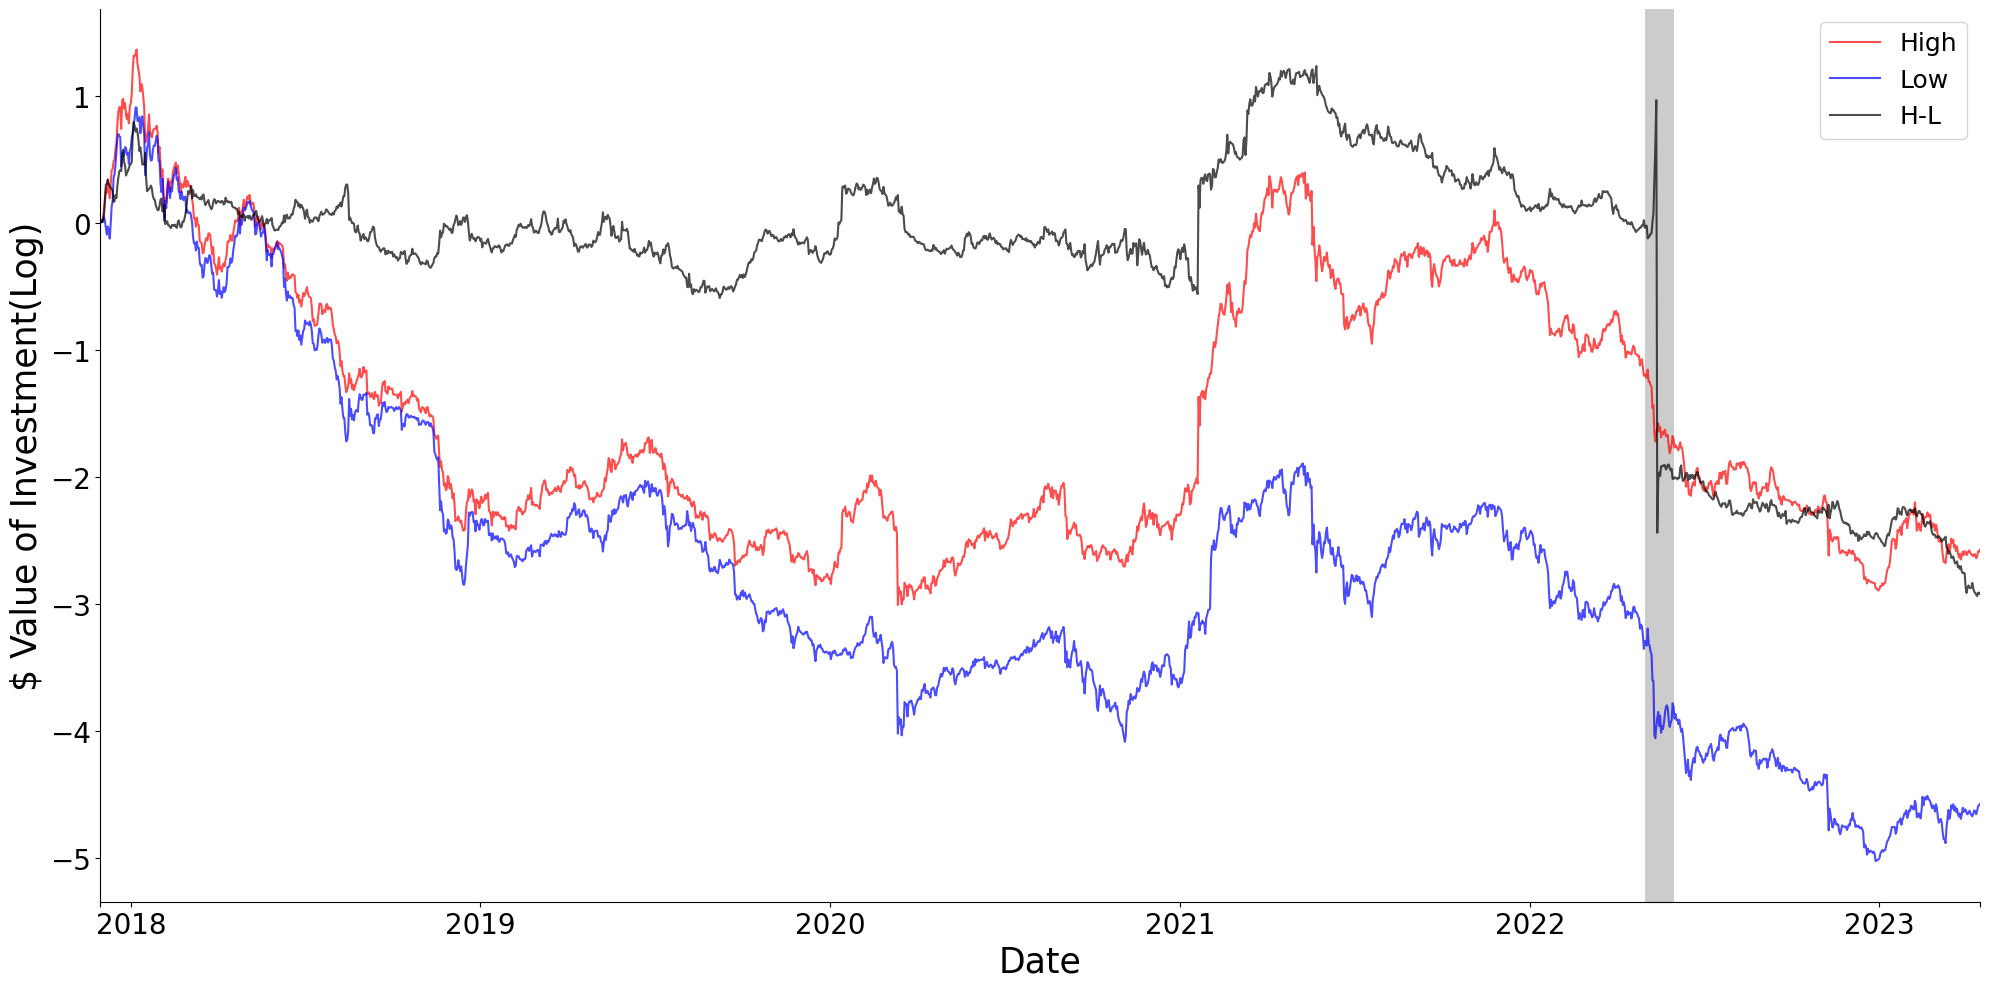

In [15]:
import matplotlib.dates as mdates

np.log((fin_c["Long_Q5"] + 1).cumprod()).plot(figsize=(20,10), c="r", alpha=0.7, fontsize=20)
np.log((fin_c["Long_Q1"] + 1).cumprod()).plot(figsize=(20,10), c="b", alpha=0.7)
np.log((fin_c["LS-cross"] + 1).cumprod()).plot(figsize=(20,10),c="k", alpha=0.7)


plt.legend(["High", "Low","H-L"], fontsize=18)
plt.xlabel("Date", fontsize=25)
plt.ylabel("\$ Value of Investment(Log)", fontsize=25)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

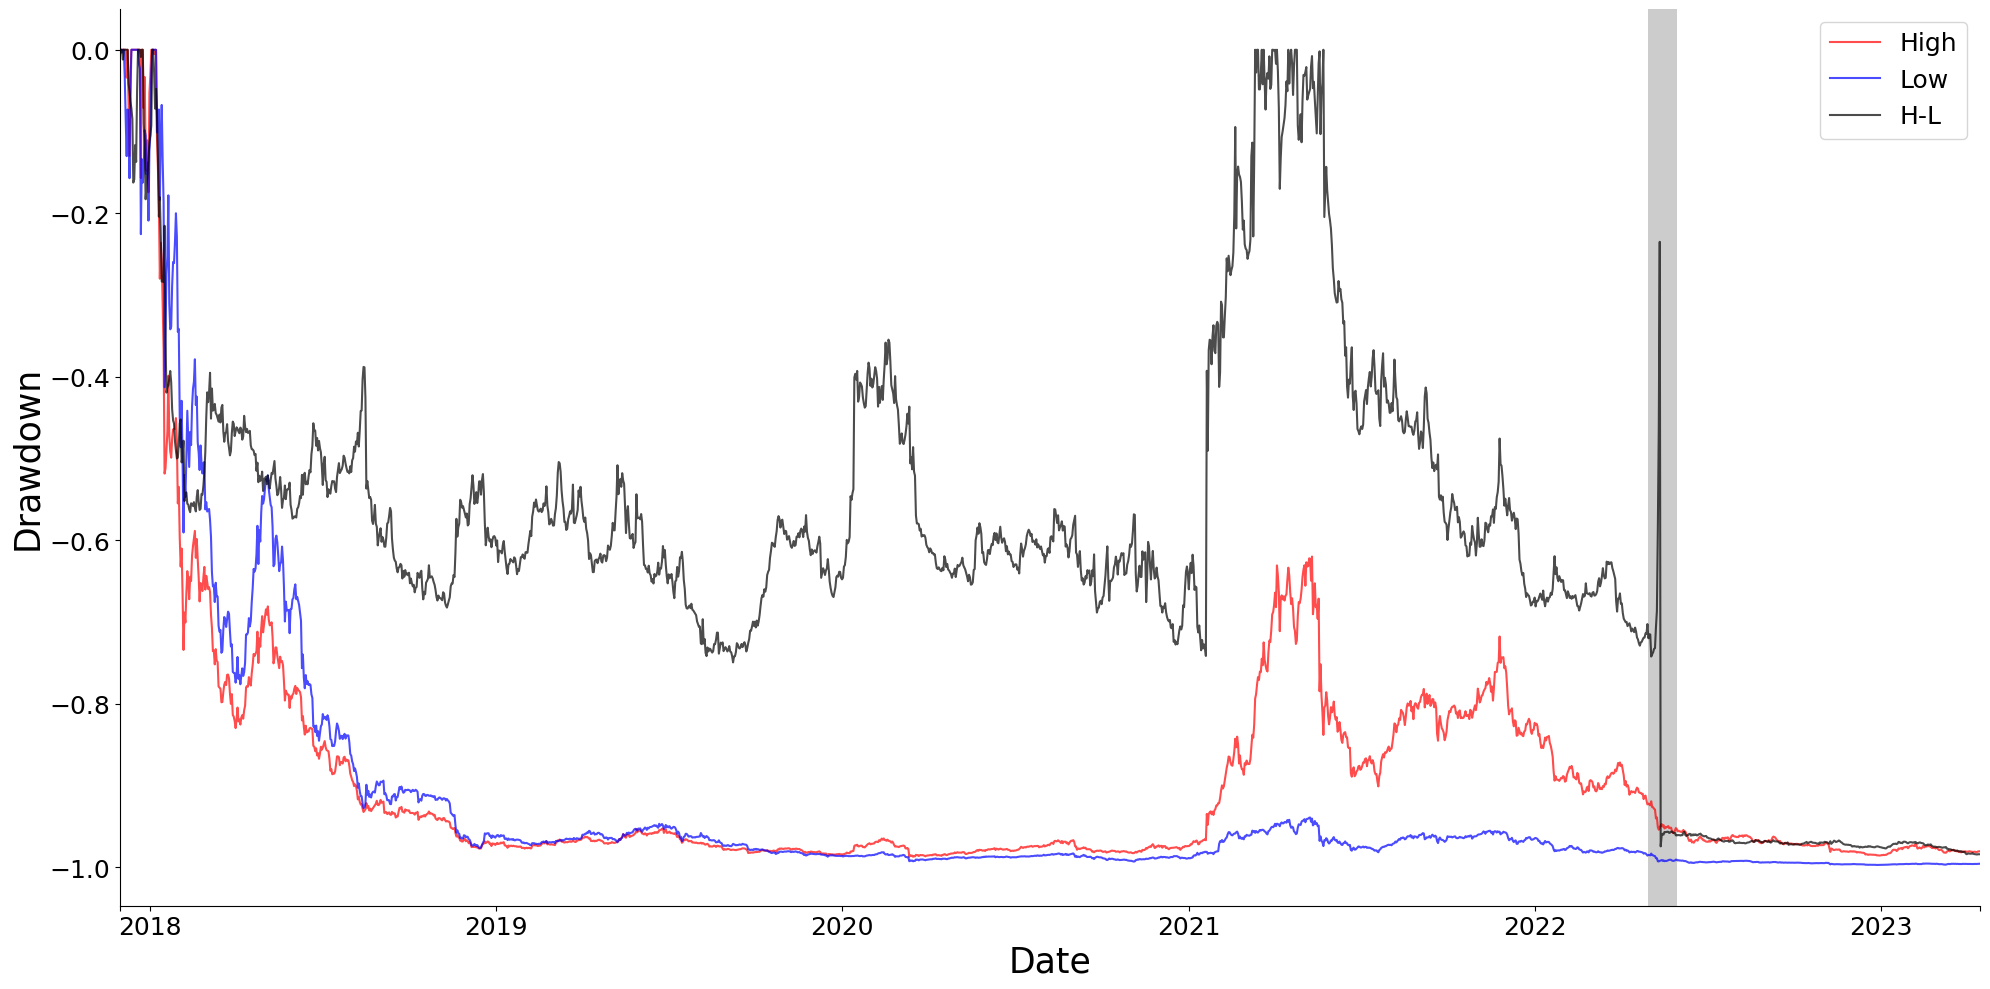

In [16]:
high = (fin_c["Long_Q5"] + 1).cumprod()
low = (fin_c["Long_Q1"] + 1).cumprod()
h_l = (fin_c["LS-cross"] + 1).cumprod()

high_peak = high.cummax()
low_peak = low.cummax()
h_l_peak = h_l.cummax()

high_dd = (high - high_peak) / high_peak
low_dd = (low - low_peak) / low_peak
h_l_dd = (h_l - h_l_peak) / h_l_peak

pd.concat([high_dd, low_dd, h_l_dd], axis=1,
          keys=["High","Low","H-L"]).plot(figsize=(20,10), 
                                          color=["red","blue","black"],
                                          alpha=0.7,
                                          fontsize=18)

plt.xlabel("Date", fontsize=25)
plt.ylabel("Drawdown", fontsize=25)

start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.legend(["High", "Low","H-L"], fontsize=18)

plt.minorticks_off()
plt.tight_layout();

In [17]:
mytool.print_statistics(fin_c)

,Long_Q1,Long_Q2,Long_Q3,Long_Q4,Long_Q5,LS-cross
CAGR,-0.573400,-0.323400,-0.113200,0.006600,-0.381600,-0.418400
Mean,-0.291640,0.095990,0.326870,0.447510,0.085990,0.279950
STD,1.044515,0.970190,0.929099,0.919868,1.081028,1.044941
MDD,0.997000,0.978000,0.965000,0.953000,0.987000,0.985000
Sharpe,-0.279211,0.098939,0.351814,0.486494,0.079545,0.267910


No cap

In [ ]:
momentum_cmkt = {}

momentum_future = [weekly_momentum_value_weighted.remote(price_df=ray_price,
                                                                mktcap_df=ray_mktcap,
                                                                daily_rtn_df = ray_daily_rtn,
                                                                weekly_rtn_df = ray_weekly_rtn,
                                                                mask_df = ray_mask,
                                                                fee_rate = 0.0015,
                                                                n_group=5,
                                                                day_of_week=day,
                                                                ) 
              for day in days_lst]

momentum_result = ray.get(momentum_future)

In [ ]:
momentum_result_dict = {"MON":momentum_result[0],
                        "TUE":momentum_result[1],
                        "WED":momentum_result[2],
                        "THU":momentum_result[3],
                        "FRI":momentum_result[4],
                        "SAT":momentum_result[5],
                        "SUN":momentum_result[6]}

In [ ]:
final = {}

for day in days_lst:
    df_day = momentum_result_dict[day]
    #print(df_day.values())
    
    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final[day] = concat_df

fin = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]:
    concat_series = pd.concat([df[pf] for key, df in final.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series.index[0] - pd.Timedelta(days=1)
    concat_series[start_idx] = 7
    fin[pf] = concat_series.sort_index().pct_change().fillna(0)

In [ ]:
np.log((fin_c["Long_Q5"] + 1).cumprod()).plot(figsize=(20,10), c="r", alpha=0.7)
np.log((fin_c["Long_Q1"] + 1).cumprod()).plot(figsize=(20,10), c="b", alpha=0.7)
np.log((fin_c["LS-cross"] + 1).cumprod()).plot(figsize=(20,10),c="k", alpha=0.7)


plt.legend(["High", "Low","H-L"])
plt.xlabel("Date", fontsize=18)
plt.ylabel("\$ Value of Investment(Log)", fontsize=18)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [ ]:
mytool.print_statistics(fin_c)

j-k Momentum

In [6]:
momentum_capped_cmkt = {}

momentum_capped_future = [jk_momentum_value_weighted_capped.remote(mktcap_df=ray_mktcap,
                                                                   daily_rtn_df = ray_daily_rtn,
                                                                   mask_df = ray_mask,
                                                                   fee_rate = 0.0015,
                                                                   n_group=5,
                                                                   day_of_week=day,
                                                                   num_cap=0.95 # 5%
                                                                    ) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [7]:
momentum_result_dict_c = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

In [8]:
final_c = {}

for day in days_lst:
    df_day = momentum_result_dict_c[day]
    #print(df_day.values())
    
    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final_c[day] = concat_df

fin_c = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]:
    concat_series_c = pd.concat([df[pf] for key, df in final_c.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series_c.index[0] - pd.Timedelta(days=1)
    concat_series_c[start_idx] = 7
    fin_c[pf] = concat_series_c.sort_index().pct_change().fillna(0)

In [9]:
font = {'family': 'serif', 'style': 'italic'}

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

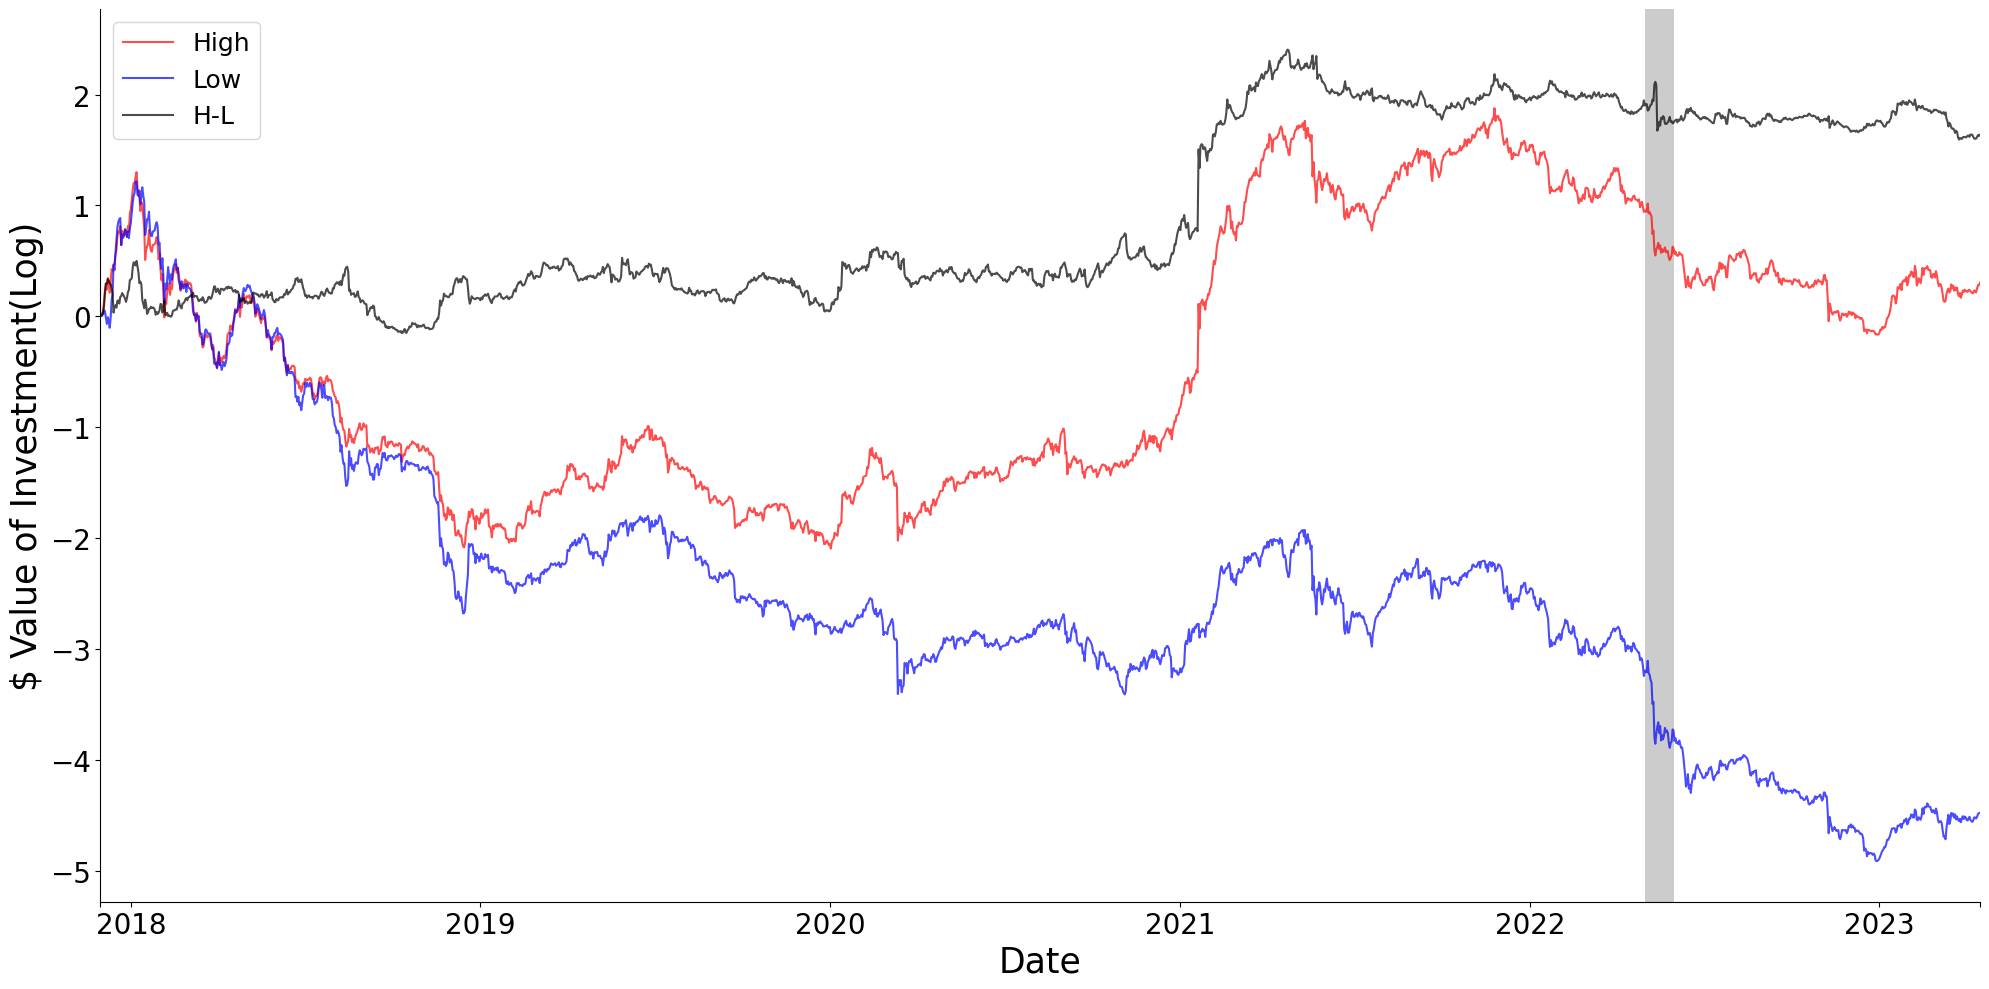

In [10]:
import matplotlib.dates as mdates

np.log((fin_c["Long_Q5"] + 1).cumprod()).plot(figsize=(20,10), c="r", alpha=0.7, fontsize=20)
np.log((fin_c["Long_Q1"] + 1).cumprod()).plot(figsize=(20,10), c="b", alpha=0.7)
np.log((fin_c["LS-cross"] + 1).cumprod()).plot(figsize=(20,10),c="k", alpha=0.7)


plt.legend(["High", "Low","H-L"], fontsize=18)
plt.xlabel("Date", fontsize=25)
plt.ylabel("\$ Value of Investment(Log)", fontsize=25)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

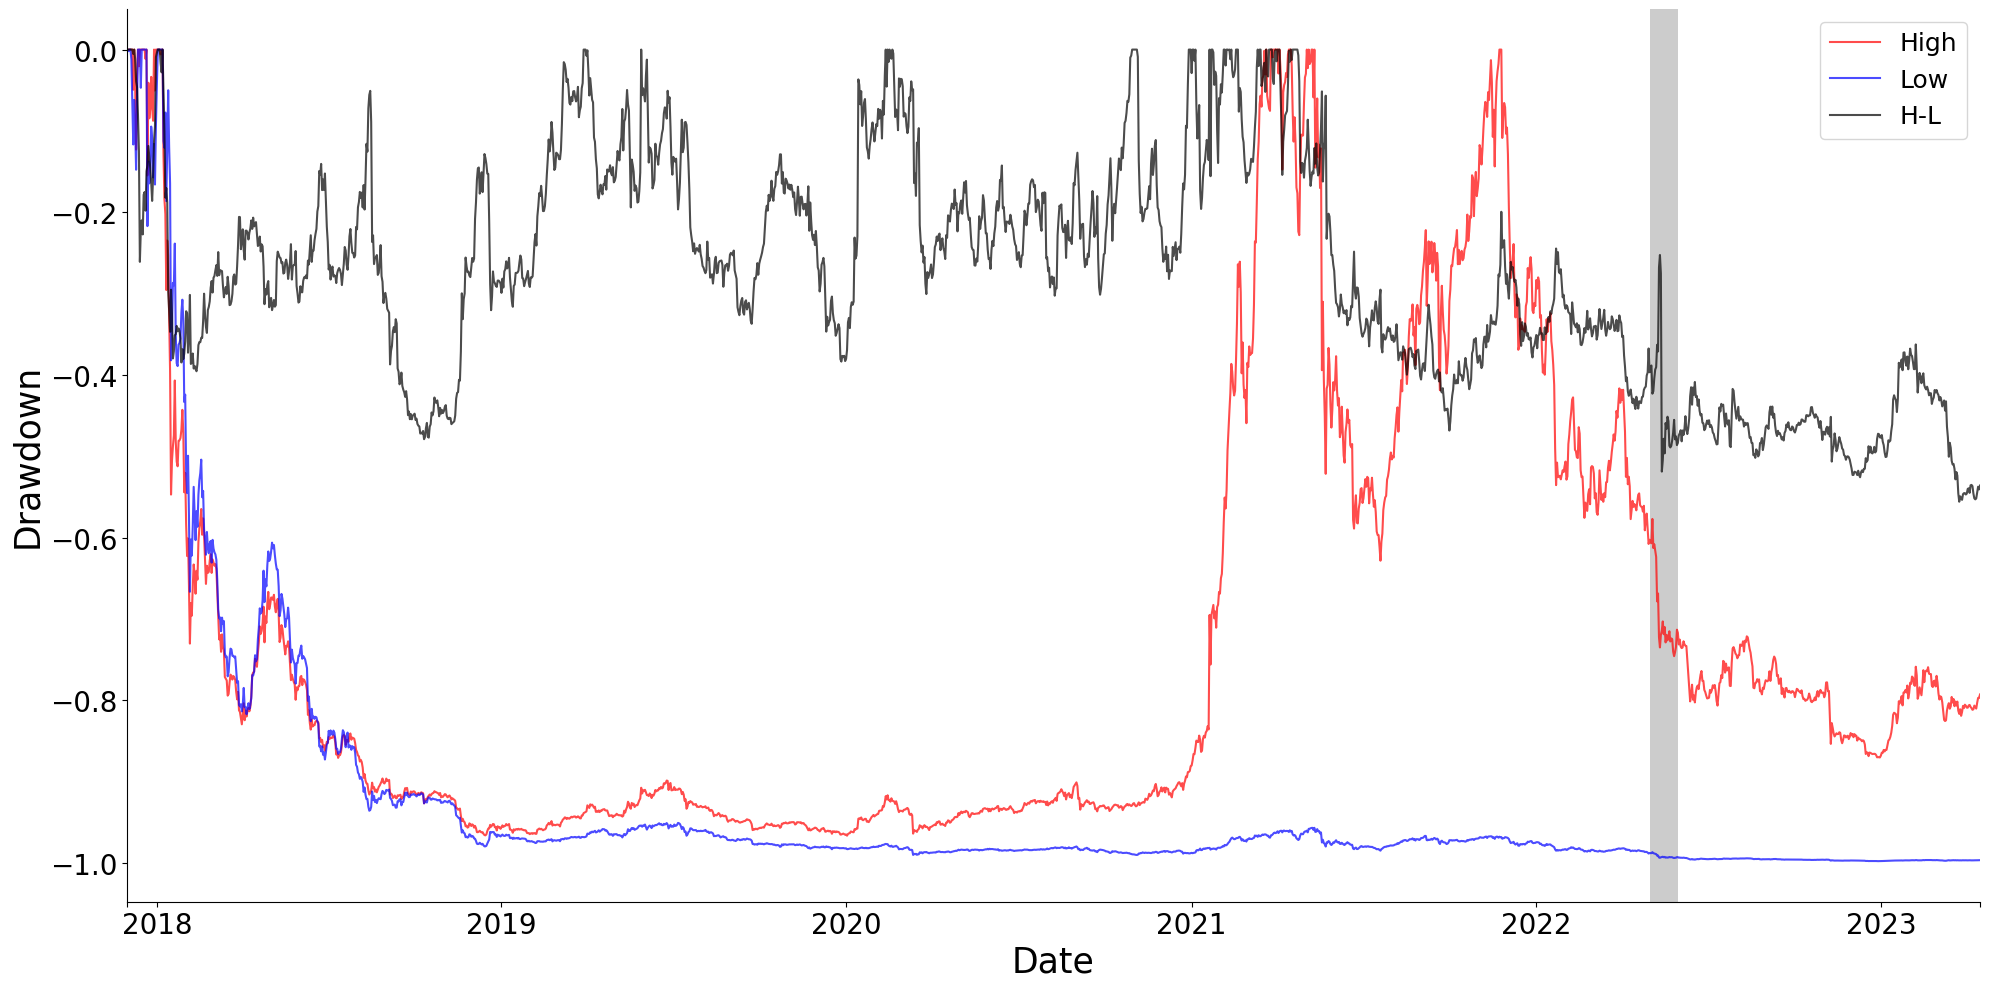

In [11]:
high = (fin_c["Long_Q5"] + 1).cumprod()
low = (fin_c["Long_Q1"] + 1).cumprod()
h_l = (fin_c["LS-cross"] + 1).cumprod()

high_peak = high.cummax()
low_peak = low.cummax()
h_l_peak = h_l.cummax()

high_dd = (high - high_peak) / high_peak
low_dd = (low - low_peak) / low_peak
h_l_dd = (h_l - h_l_peak) / h_l_peak

pd.concat([high_dd, low_dd, h_l_dd], axis=1,
          keys=["High","Low","H-L"]).plot(figsize=(20,10), 
                                          color=["red","blue","black"],
                                          alpha=0.7,
                                          fontsize=20)

plt.xlabel("Date", fontsize=25)
plt.ylabel("Drawdown", fontsize=25)

plt.legend(["High", "Low","H-L"], fontsize=18)


start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [14]:
#fin_c["MKT"] = mkt.loc["2017-12-30":]
stat = mytool.print_statistics(fin_c).iloc[[0,2,3]]
stat.loc["Sharpe"] = stat.loc["CAGR"] / stat.loc["STD"]
stat.iloc[:3, :] = (stat.iloc[:3, :] * 100).round(2)

stat2 = stat.loc[:, ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]]
stat2.columns = ["1","2","3","4","5","5-1"]
print(stat2.to_latex())
#stat2

\begin{tabular}{lrrrrrr}
\toprule
 & 1 & 2 & 3 & 4 & 5 & 5-1 \\
\midrule
CAGR & -56.550000 & -19.560000 & -0.140000 & 11.320000 & 5.480000 & 35.350000 \\
STD & 96.450000 & 92.470000 & 89.850000 & 88.310000 & 100.070000 & 74.190000 \\
MDD & 99.800000 & 97.000000 & 94.800000 & 93.600000 & 96.700000 & 55.600000 \\
Sharpe & -0.586297 & -0.211525 & -0.001558 & 0.128182 & 0.054764 & 0.476495 \\
\bottomrule
\end{tabular}



vol weighted jk

In [6]:
momentum_capped_cmkt = {}

momentum_capped_future = [jk_volume_weighted_capped.remote(mktcap_df=ray_mktcap,
                                                           vol_df = ray_vol,
                                                           daily_rtn_df = ray_daily_rtn,
                                                           mask_df = ray_mask,
                                                           fee_rate = 0.0015,
                                                           n_group=5,
                                                           day_of_week=day,
                                                           num_cap=0.95 # 5%
                                                                       ) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [7]:
momentum_result_dict_c = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

In [8]:
final_c = {}

for day in days_lst:
    df_day = momentum_result_dict_c[day]
    #print(df_day.values())
    
    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final_c[day] = concat_df

fin_c = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]:
    concat_series_c = pd.concat([df[pf] for key, df in final_c.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series_c.index[0] - pd.Timedelta(days=1)
    concat_series_c[start_idx] = 7
    fin_c[pf] = concat_series_c.sort_index().pct_change().fillna(0)

In [9]:
font = {'family': 'serif', 'style': 'italic'}

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

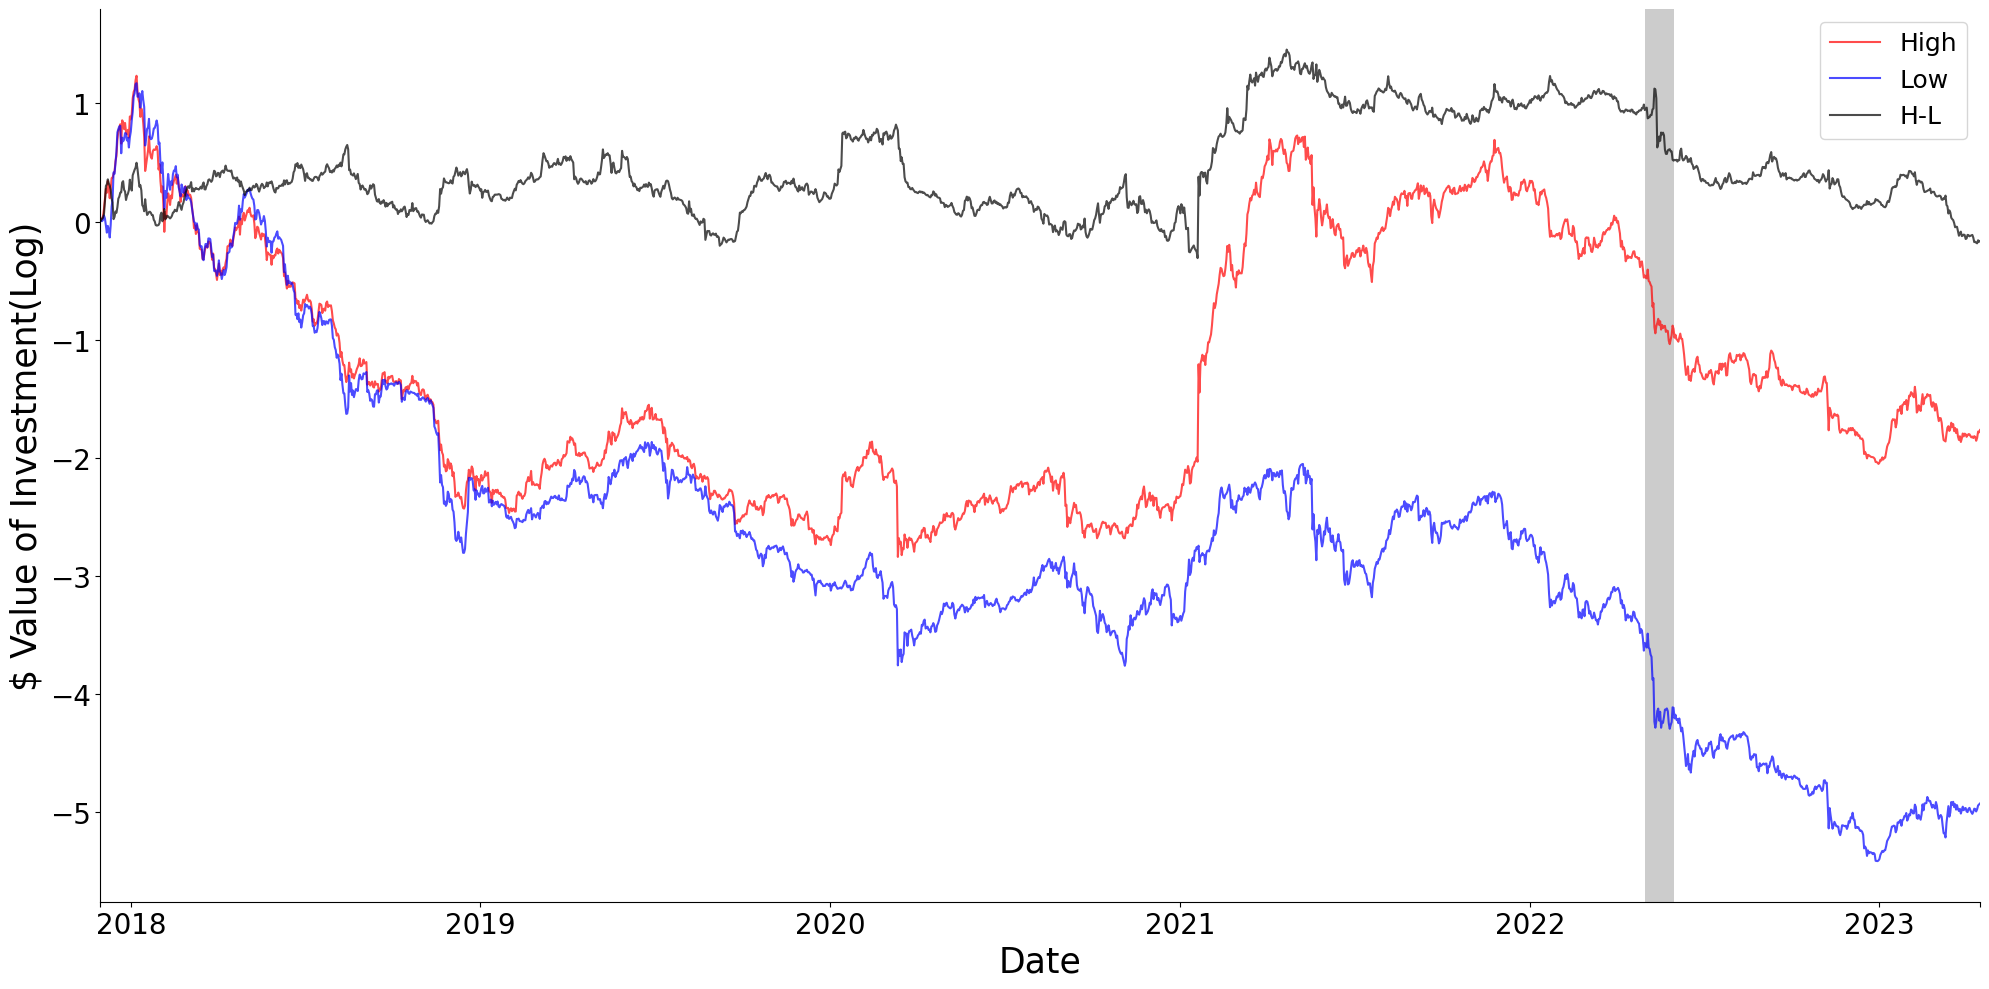

In [10]:
import matplotlib.dates as mdates

np.log((fin_c["Long_Q5"] + 1).cumprod()).plot(figsize=(20,10), c="r", alpha=0.7, fontsize=20)
np.log((fin_c["Long_Q1"] + 1).cumprod()).plot(figsize=(20,10), c="b", alpha=0.7)
np.log((fin_c["LS-cross"] + 1).cumprod()).plot(figsize=(20,10),c="k", alpha=0.7)


plt.legend(["High", "Low","H-L"], fontsize=18)
plt.xlabel("Date", fontsize=25)
plt.ylabel("\$ Value of Investment(Log)", fontsize=25)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

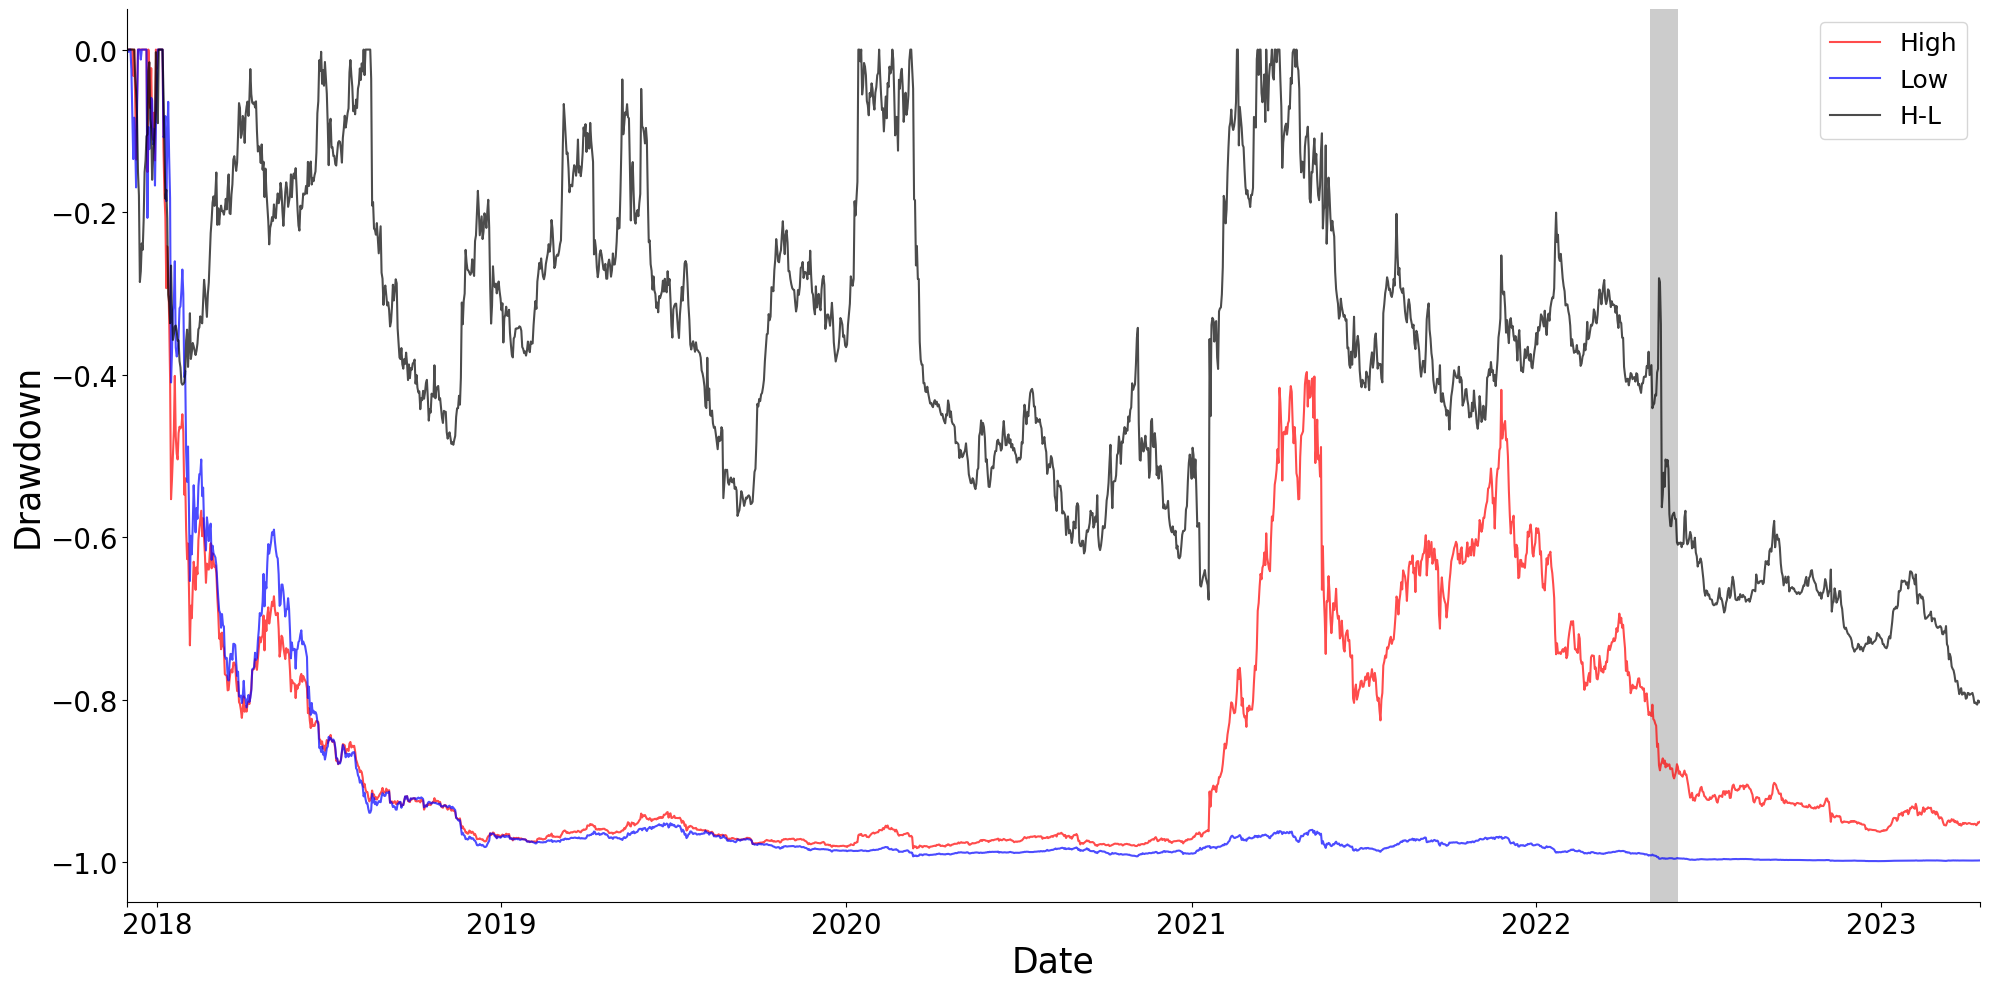

In [11]:
high = (fin_c["Long_Q5"] + 1).cumprod()
low = (fin_c["Long_Q1"] + 1).cumprod()
h_l = (fin_c["LS-cross"] + 1).cumprod()

high_peak = high.cummax()
low_peak = low.cummax()
h_l_peak = h_l.cummax()

high_dd = (high - high_peak) / high_peak
low_dd = (low - low_peak) / low_peak
h_l_dd = (h_l - h_l_peak) / h_l_peak

pd.concat([high_dd, low_dd, h_l_dd], axis=1,
          keys=["High","Low","H-L"]).plot(figsize=(20,10), 
                                          color=["red","blue","black"],
                                          alpha=0.7,
                                          fontsize=20)

plt.xlabel("Date", fontsize=25)
plt.ylabel("Drawdown", fontsize=25)

plt.legend(["High", "Low","H-L"], fontsize=18)


start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [12]:
#fin_c["MKT"] = mkt.loc["2017-12-30":]
stat = mytool.print_statistics(fin_c).iloc[[0,2,3]]
stat.loc["Sharpe"] = stat.loc["CAGR"] / stat.loc["STD"]
stat.iloc[:3, :] = (stat.iloc[:3, :] * 100).round(2)

stat2 = stat.loc[:, ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]]
stat2.columns = ["1","2","3","4","5","5-1"]
print(stat2.to_latex())
#stat2

\begin{tabular}{lrrrrrr}
\toprule
 & 1 & 2 & 3 & 4 & 5 & 5-1 \\
\midrule
CAGR & -60.020000 & -26.820000 & -16.160000 & -8.780000 & -28.200000 & -3.230000 \\
STD & 102.140000 & 96.690000 & 93.330000 & 92.140000 & 114.660000 & 78.870000 \\
MDD & 99.900000 & 97.000000 & 96.600000 & 95.800000 & 98.300000 & 80.600000 \\
Sharpe & -0.587617 & -0.277386 & -0.173155 & -0.095288 & -0.245951 & -0.040952 \\
\bottomrule
\end{tabular}

